# 1.0 Get Data Of Stock Market

* 本篇代码用来查询所有股票数据，所有导出的数据都将导出到stockdata文件夹内，方便管理查看。
* 平台api方面，国内用tushare，国外用的雅虎。
* 本篇代码也计划用来做数据清洗并且数据展示，处理好的文件也存在stockdata文件夹里面。

In [1]:
import time

print("Hello,stock market");
import pandas as pd
from datetime import datetime
start_time = datetime.now()
## todo: calculating the time of import libraries
#先引入后面分析、可视化等可能用到的库
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
#正常显示画图时出现的中文和负号
from pylab import mpl
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# todo: solve chinese problem for plt
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
print("Load Time: ",datetime.now()-start_time)

Hello,stock market
Load Time:  0:00:01.361550


## 1.1 use tushare api get data

In [2]:
# login tushare, use token
pro = ts.pro_api('f7b384108cbed0026a4dfa35835f75b0fb9d04673a067e8b75d8810f')


def getStockCompanyInformation(status='L', stock_code=''):
    """
    得到目前所有的股票公司信息
    :param status: 上市状态 L上市 D退市 P暂停上市，默认是L
    :param stock_code: TS股票代码
    :return:
    """

    if stock_code== '':
        rawStockCompanyDataInTushare = pro.stock_basic(exchange='', list_status=status, fields='ts_code,symbol,fullname,enname,name,area,industry,list_date')
    else:
        rawStockCompanyDataInTushare = pro.stock_basic(ts_code=stock_code, exchange='', list_status=status, fields='ts_code,symbol,fullname,enname,name,area,industry,list_date')

    rawStockCompanyDataInTushare['ts_code']=rawStockCompanyDataInTushare['ts_code'].astype(str)
    rawStockCompanyDataInTushare['symbol']=rawStockCompanyDataInTushare['symbol'].astype('float64')
    rawStockCompanyDataInTushare['name']=rawStockCompanyDataInTushare['name'].astype(str)
    rawStockCompanyDataInTushare['area']=rawStockCompanyDataInTushare['area'].astype(str)
    rawStockCompanyDataInTushare['industry']=rawStockCompanyDataInTushare['industry'].astype(str)
    rawStockCompanyDataInTushare['fullname']=rawStockCompanyDataInTushare['fullname'].astype(str)
    rawStockCompanyDataInTushare['enname']=rawStockCompanyDataInTushare['enname'].astype(str)
    rawStockCompanyDataInTushare['list_date']=rawStockCompanyDataInTushare['list_date'].astype('float64')
    return rawStockCompanyDataInTushare


# 拉取数据
def getDailyStockData(stock_code="",start="20180101",end="20230101"):
    """
    拉取股票日结交易信息，时间段默认 2018-1-1 到 2022-1-1，注意：该函数单次只能查询6000条记录。
    :param stock_code: 股票代码，默认为空，输入为空的时候，拉取这段时期所有股票的交易消息；若不为空，拉去这只股票这段时间的交易消息
    :param start: 开始日期
    :param end: 结束日期
    :return:
    """
    rawData = pro.daily(**{
        "ts_code": stock_code,
        "trade_date": "",
        "start_date": start,
        "end_date": end,
        "offset": "",
        "limit": "",
    }, fields=[
        "ts_code",
        "trade_date",
        "open",
        "high",
        "low",
        "close",
        "pre_close",
        "change",
        "pct_chg",
        "vol",
        "amount"
    ])
    rawData['ts_code']=rawData['ts_code'].astype(str)
    rawData['trade_date']=rawData['trade_date'].astype('float64')
    return rawData


In [3]:
rawCompanyDataInTushare=getStockCompanyInformation()
print("The shape of the data frame: {}".format(rawCompanyDataInTushare.shape))
print("The types in the data frame {}".format(rawCompanyDataInTushare.dtypes))
rawCompanyDataInTushare

The shape of the data frame: (5166, 8)
The types in the data frame ts_code       object
symbol       float64
name          object
area          object
industry      object
fullname      object
enname        object
list_date    float64
dtype: object


,ts_code,symbol,name,area,industry,fullname,enname,list_date
0,000001.SZ,1.0,平安银行,深圳,银行,平安银行股份有限公司,"Ping An Bank Co., Ltd.",19910403.0
1,000002.SZ,2.0,万科A,深圳,全国地产,万科企业股份有限公司,"China Vanke Co.,Ltd.",19910129.0
2,000004.SZ,4.0,ST国华,深圳,软件服务,深圳国华网安科技股份有限公司,Shenzhen Guohua Network Security Technology Co...,19910114.0
3,000005.SZ,5.0,ST星源,深圳,环境保护,深圳世纪星源股份有限公司,Shenzhen Fountain Corporation,19901210.0
4,000006.SZ,6.0,深振业A,深圳,区域地产,深圳市振业(集团)股份有限公司,"Shenzhen Zhenye(Group) Co., Ltd",19920427.0
...,...,...,...,...,...,...,...,...
5161,873305.BJ,873305.0,九菱科技,None,None,荆州九菱科技股份有限公司,"Jingzhou Julin Science And Technology Co.,Ltd",20221221.0
5162,873339.BJ,873339.0,恒太照明,None,None,江苏恒太照明股份有限公司,"Jiangsu Ever-Tie Lighting Co., Ltd",20221117.0
5163,873527.BJ,873527.0,夜光明,None,None,浙江夜光明光电科技股份有限公司,"Zhejiang Ygm Technology Co.,Ltd",20221027.0
5164,873593.BJ,873593.0,鼎智科技,None,None,江苏鼎智智能控制科技股份有限公司,Jiangsu DINGS Intelligent Control Technology C...,20230413.0


In [4]:
rawDailyDataInTushare=getDailyStockData()
print("The shape of the data frame: {}".format(rawDailyDataInTushare.shape))
print("The types in the data frame:\n{}".format(rawDailyDataInTushare.dtypes))
print("The unique stock code: {}".format(len(rawDailyDataInTushare['ts_code'].unique())))
rawDailyDataInTushare

The shape of the data frame: (6000, 11)
The types in the data frame:
ts_code        object
trade_date    float64
open          float64
high          float64
low           float64
close         float64
pre_close     float64
change        float64
pct_chg       float64
vol           float64
amount        float64
dtype: object
The unique stock code: 5061


,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,002198.SZ,20221230.0,6.39,6.57,6.33,6.52,6.40,0.12,1.8750,101579.12,65646.164
1,002199.SZ,20221230.0,6.36,6.43,6.28,6.39,6.29,0.10,1.5898,38684.00,24640.014
2,002194.SZ,20221230.0,9.13,9.26,9.07,9.21,9.10,0.11,1.2088,101101.41,92895.425
3,002181.SZ,20221230.0,5.28,5.52,5.28,5.46,5.31,0.15,2.8249,547665.70,297495.407
4,002195.SZ,20221230.0,1.99,2.02,1.98,2.01,1.98,0.03,1.5152,444728.72,89088.620
...,...,...,...,...,...,...,...,...,...,...,...
5995,300185.SZ,20221229.0,2.43,2.43,2.38,2.39,2.43,-0.04,-1.6461,169697.00,40744.559
5996,002212.SZ,20221229.0,9.51,9.93,9.48,9.85,9.59,0.26,2.7112,166568.42,163068.690
5997,002213.SZ,20221229.0,16.37,16.37,15.61,15.68,14.88,0.80,5.3763,238641.86,386408.221
5998,002397.SZ,20221229.0,4.54,4.67,4.51,4.54,4.60,-0.06,-1.3043,127870.79,58483.435


In [5]:
##test
testDailyStockData=getDailyStockData(stock_code="000006.SZ")
testDailyStockData

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000006.SZ,20221230.0,6.29,6.46,6.21,6.30,6.13,0.17,2.7732,1280164.06,807162.552
1,000006.SZ,20221229.0,6.60,6.65,6.13,6.13,6.81,-0.68,-9.9853,2067778.94,1305956.659
2,000006.SZ,20221228.0,6.47,7.17,6.40,6.81,6.64,0.17,2.5602,2646897.32,1789639.303
3,000006.SZ,20221227.0,6.00,6.64,5.96,6.64,6.04,0.60,9.9338,2469265.08,1612828.768
4,000006.SZ,20221226.0,5.69,6.18,5.65,6.04,5.91,0.13,2.1997,1502166.93,894013.083
...,...,...,...,...,...,...,...,...,...,...,...
1168,000006.SZ,20180314.0,8.55,8.65,8.28,8.29,8.70,-0.41,-4.7100,596514.45,502396.942
1169,000006.SZ,20180313.0,8.65,8.88,8.60,8.70,8.65,0.05,0.5800,607777.85,530832.951
1170,000006.SZ,20180312.0,8.61,8.79,8.49,8.65,8.80,-0.15,-1.7000,738316.89,635967.707
1171,000006.SZ,20180309.0,8.61,9.23,8.44,8.80,8.87,-0.07,-0.7900,1119431.92,971167.257


In [6]:
###由于Toshare社区限制每次查询只能拿到 6000 行日结交易信息（每日每公司为一行），而且每分钟只能查500次。为了得到当前所有上市公司，每次查询只查一家上市公司而且将会延迟0.2秒
def bindDailyAndCompanyInformation():
    notIncludedData=['name']

    startTime=datetime.now()
    companies=getStockCompanyInformation()
    bindData=pd.DataFrame()
    i=2
    for company in companies['ts_code'].to_numpy():
        dailyData=getDailyStockData(stock_code=company)
        for header in companies.columns:
            if header!="ts_code":
                #test only
                # print("------------------------------------")
                # print(companies[companies['ts_code'] == company][header].values.repeat(5))
                # print(dailyData.shape[0])
                # print("------------------------------------")
                dailyData[header]= companies[companies['ts_code'] == company][header].values.repeat(dailyData.shape[0])

        dailyData=dailyData.drop(columns=notIncludedData)
        bindData=bindData.append(dailyData)
        #time.sleep(0.15)
        ###########test only
        #print(dailyData)
        # if i==1:
        #     break
        # else:
        #     i-=1
        ###########

    timeConsume=datetime.now()-startTime;
    print("Run time: {}".format(timeConsume))
    return bindData


In [7]:
###此cell仅用于下载股票数据，由于信息量庞大，可导入下好的 TushareRawData.csv 文件即可
# theBindDataInTushare=bindDailyAndCompanyInformation()
theBindDataInTushare=pd.read_csv('stockData/TushareRawData.csv')
print("The shape of the data frame: {}".format(theBindDataInTushare.shape))
print("The types in the data frame:\n{}".format(theBindDataInTushare.dtypes))
print("The unique stock code: {}".format(len(theBindDataInTushare['ts_code'].unique())))
# theBindDataInTushare.to_csv('stockData/TushareRawData.csv', header=theBindDataInTushare.columns, index=False)



The shape of the data frame: (4808334, 16)
The types in the data frame:
ts_code        object
trade_date      int64
open          float64
high          float64
low           float64
close         float64
pre_close     float64
change        float64
pct_chg       float64
vol           float64
amount        float64
area           object
industry       object
fullname       object
enname         object
list_date       int64
dtype: object
The unique stock code: 5061


In [8]:
###不知道为什么有100家公司查不到，手动查询看看情况，然后手动合并吧
missedCompany=[]
bindCompany=theBindDataInTushare['ts_code'].unique()
for code in rawCompanyDataInTushare['ts_code'].values:
    if code not in bindCompany:
        missedCompany.append(code)


# for code in missedCompany:
#     print("-------------------------------------")
#     print(getDailyStockData(stock_code=code,end="20220505"))
#     print(getStockCompanyInformation(stock_code=code))
#     print("-------------------------------------")

print("The num of miss company: {}".format(len(missedCompany)))

###这些股票查不到，这些公司基本都是2023年上市的，可能数据还没更新吧

The num of miss company: 105


C:\Users\87066\AppData\Local\Temp\ipykernel_18252\3005412715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TCLStock[TCLStock['trade_date']<20200000.0]['trade_date']=pd.to_datetime(TCLStock[TCLStock['trade_date']<20200000.0]['trade_date'])


68765    20221230
68766    20221229
68767    20221228
68768    20221227
68769    20221226
           ...   
69974    20180108
69975    20180105
69976    20180104
69977    20180103
69978    20180102
Name: trade_date, Length: 1214, dtype: int64


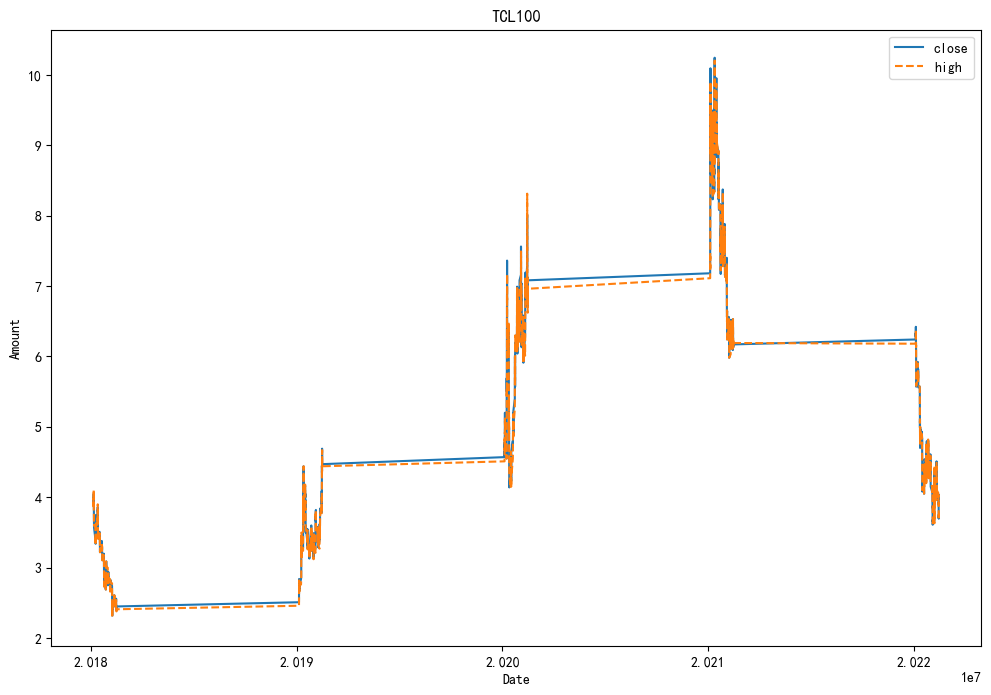

In [14]:
TCLStock=theBindDataInTushare[theBindDataInTushare['ts_code']=="000100.SZ"]
TCLStock[TCLStock['trade_date']<20200000]['trade_date']=pd.to_datetime(TCLStock[TCLStock['trade_date']<20200000]['trade_date'])
print(TCLStock['trade_date'])
plt.figure(figsize=(12,8))
plt.plot(TCLStock['trade_date'],TCLStock['close'],label="close")
plt.plot(TCLStock['trade_date'],TCLStock['open'],label="high",linestyle = "--")
plt.xlabel("Date")
plt.ylabel("Amount")
plt.title('TCL100')
plt.legend()   #打上标签
plt.show()

## 1.2 use yfinance (雅虎非官方API) api get stock data

In [10]:
data = yf.download(tickers=['AMD'],start='2018-01-1',end='2023-01-01')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,10.420000,11.020000,10.340000,10.980000,10.980000,44146300
2018-01-03,11.610000,12.140000,11.360000,11.550000,11.550000,154066700
2018-01-04,12.100000,12.430000,11.970000,12.120000,12.120000,109503000
2018-01-05,12.190000,12.220000,11.660000,11.880000,11.880000,63808900
2018-01-08,12.010000,12.300000,11.850000,12.280000,12.280000,63346000
...,...,...,...,...,...,...
2022-12-23,63.110001,64.660004,62.720001,64.519997,64.519997,45923000
2022-12-27,63.869999,64.279999,62.970001,63.270000,63.270000,36086000
2022-12-28,62.540001,63.540001,61.959999,62.570000,62.570000,39526500


[*********************100%***********************]  1 of 1 completed


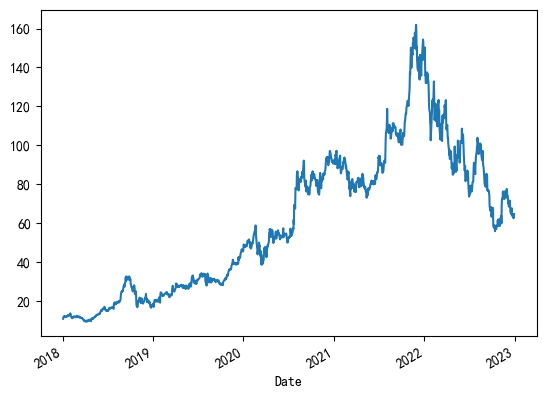

In [11]:
data = yf.download(['AMD'],'2018-01-01','2023-01-01')
data["Close"].plot()
plt.show()

In [12]:
rawDailyDataInTushare.to_csv('stockData/test.csv', header=rawDailyDataInTushare.columns, index=False)